#################################################################################################################################
#                                         Importing of Relevant Libraries
#################################################################################################################################

In [102]:
!pip install sklearn
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from urllib.parse import urlparse
from nltk.tokenize import RegexpTokenizer

!pip install tldextract
import tldextract

!pip install eli5
import eli5

#################################################################################################################################
#                                        Simple Cleaning of Data
#################################################################################################################################

In [103]:
df = pd.read_csv("/Users/atherialdawn/Documents/Programming Stuff/MLDA DLW 2022 Hackathon/dataset_phishing.csv")
df.head()

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate


In [104]:
df_grp = df.groupby(["url"])[["status"]].sum().reset_index()
df_grp.head()

,url,status
0,http://00324il.moonfruit.com,phishing
1,http://02dfbe20-6956-4be6-ba22-36ae0e0d3053.ht...,phishing
2,http://03418f6.netsolhost.com/FF7AADF203DF6C7A...,phishing
3,http://03418f6.netsolhost.com/FF7AADF203DF6C7A...,phishing
4,http://03418f6.netsolhost.com/FF7AADF203DF6C7A...,phishing


In [105]:
df_grp.replace(to_replace = "phishing", value = "1", inplace = True)
df_grp.replace(to_replace = "legitimate", value = "0", inplace = True)
df_grp

,url,status
0,http://00324il.moonfruit.com,1
1,http://02dfbe20-6956-4be6-ba22-36ae0e0d3053.ht...,1
2,http://03418f6.netsolhost.com/FF7AADF203DF6C7A...,1
3,http://03418f6.netsolhost.com/FF7AADF203DF6C7A...,1
4,http://03418f6.netsolhost.com/FF7AADF203DF6C7A...,1
...,...,...
11424,https://zmail221.appspot.com,1
11425,https://zonasegura1.bn.com.multiservicioswebth...,1
11426,https://zoomic.io/wp-includes/neworder/bizmail...,1
11427,https://zoryanvk.wordpress.com/,0


#################################################################################################################################
#                                        Creation of Evaluation Model
#################################################################################################################################

In [106]:
def parse_url(url: str): #Optional[Dict[str, str]] --> Saw this online, but not too sure what this is
    try:
        no_scheme = not url.startswith('https://') and not url.startswith('http://')
        if no_scheme:
            parsed_url = urlparse(f"http://{url}")
            return {
                "scheme": None, #No established value for this --> Think this is for http or https
                "netloc": parsed_url.netloc,
                "path": parsed_url.path,
                "params": parsed_url.params,
                "query": parsed_url.query,
                "fragment": parsed_url.fragment,
            }
        else:
            parsed_url = urlparse(url)
            return {
                "scheme": parsed_url.scheme,
                "netloc": parsed_url.netloc,
                "path": parsed_url.path,
                "params": parsed_url.params,
                "query": parsed_url.query,
                "fragment": parsed_url.fragment,
            }
    except:
        return None

In [107]:
df_grp["parsed_url"] = df_grp.url.apply(parse_url)
df_grp

,url,status,parsed_url
0,http://00324il.moonfruit.com,1,"{'scheme': 'http', 'netloc': '00324il.moonfrui..."
1,http://02dfbe20-6956-4be6-ba22-36ae0e0d3053.ht...,1,"{'scheme': 'http', 'netloc': '02dfbe20-6956-4b..."
2,http://03418f6.netsolhost.com/FF7AADF203DF6C7A...,1,"{'scheme': 'http', 'netloc': '03418f6.netsolho..."
3,http://03418f6.netsolhost.com/FF7AADF203DF6C7A...,1,"{'scheme': 'http', 'netloc': '03418f6.netsolho..."
4,http://03418f6.netsolhost.com/FF7AADF203DF6C7A...,1,"{'scheme': 'http', 'netloc': '03418f6.netsolho..."
...,...,...,...
11424,https://zmail221.appspot.com,1,"{'scheme': 'https', 'netloc': 'zmail221.appspo..."
11425,https://zonasegura1.bn.com.multiservicioswebth...,1,"{'scheme': 'https', 'netloc': 'zonasegura1.bn...."
11426,https://zoomic.io/wp-includes/neworder/bizmail...,1,"{'scheme': 'https', 'netloc': 'zoomic.io', 'pa..."
11427,https://zoryanvk.wordpress.com/,0,"{'scheme': 'https', 'netloc': 'zoryanvk.wordpr..."


In [108]:
df_grp = pd.concat([
    df_grp.drop(['parsed_url'], axis=1),
    df_grp['parsed_url'].apply(pd.Series)
], axis=1)
df_grp

,url,status,scheme,netloc,path,params,query,fragment
0,http://00324il.moonfruit.com,1,http,00324il.moonfruit.com,,,,
1,http://02dfbe20-6956-4be6-ba22-36ae0e0d3053.ht...,1,http,02dfbe20-6956-4be6-ba22-36ae0e0d3053.htmlcompo...,/get_draft,,id=99ea0e_8eddaa8b0b3b6316a653bbd03eb5b48f.html,
2,http://03418f6.netsolhost.com/FF7AADF203DF6C7A...,1,http,03418f6.netsolhost.com,/FF7AADF203DF6C7A0B7C8A74B8164E55/,,,
3,http://03418f6.netsolhost.com/FF7AADF203DF6C7A...,1,http,03418f6.netsolhost.com,/FF7AADF203DF6C7A0B7C8A74B8164E55/,,sec=Milka%20Gostovic,
4,http://03418f6.netsolhost.com/FF7AADF203DF6C7A...,1,http,03418f6.netsolhost.com,/FF7AADF203DF6C7A0B7C8A74B8164E55/,,sec=Puc%20Kotsis,
...,...,...,...,...,...,...,...,...
11424,https://zmail221.appspot.com,1,https,zmail221.appspot.com,,,,
11425,https://zonasegura1.bn.com.multiservicioswebth...,1,https,zonasegura1.bn.com.multiservicioswebther.com,/BNlWeb/lnicio/logins.do,,,
11426,https://zoomic.io/wp-includes/neworder/bizmail...,1,https,zoomic.io,/wp-includes/neworder/bizmail.php,,email=&amp;_rand=13vqcr8bp0gud&amp;lc=1033&amp...,
11427,https://zoryanvk.wordpress.com/,0,https,zoryanvk.wordpress.com,/,,,


In [109]:
df_grp = df_grp[~df_grp.netloc.isnull()]
df_grp

,url,status,scheme,netloc,path,params,query,fragment
0,http://00324il.moonfruit.com,1,http,00324il.moonfruit.com,,,,
1,http://02dfbe20-6956-4be6-ba22-36ae0e0d3053.ht...,1,http,02dfbe20-6956-4be6-ba22-36ae0e0d3053.htmlcompo...,/get_draft,,id=99ea0e_8eddaa8b0b3b6316a653bbd03eb5b48f.html,
2,http://03418f6.netsolhost.com/FF7AADF203DF6C7A...,1,http,03418f6.netsolhost.com,/FF7AADF203DF6C7A0B7C8A74B8164E55/,,,
3,http://03418f6.netsolhost.com/FF7AADF203DF6C7A...,1,http,03418f6.netsolhost.com,/FF7AADF203DF6C7A0B7C8A74B8164E55/,,sec=Milka%20Gostovic,
4,http://03418f6.netsolhost.com/FF7AADF203DF6C7A...,1,http,03418f6.netsolhost.com,/FF7AADF203DF6C7A0B7C8A74B8164E55/,,sec=Puc%20Kotsis,
...,...,...,...,...,...,...,...,...
11424,https://zmail221.appspot.com,1,https,zmail221.appspot.com,,,,
11425,https://zonasegura1.bn.com.multiservicioswebth...,1,https,zonasegura1.bn.com.multiservicioswebther.com,/BNlWeb/lnicio/logins.do,,,
11426,https://zoomic.io/wp-includes/neworder/bizmail...,1,https,zoomic.io,/wp-includes/neworder/bizmail.php,,email=&amp;_rand=13vqcr8bp0gud&amp;lc=1033&amp...,
11427,https://zoryanvk.wordpress.com/,0,https,zoryanvk.wordpress.com,/,,,


##### The first meaningful bit of data to extract is the length of the URL.

In [110]:
df_grp["length"] = df_grp.url.str.len()

In [111]:
#The TLD is then extracted using a python library, and if no TLD is present simply add 'None'.

df_grp["tld"] = df_grp.netloc.apply(lambda nl: tldextract.extract(nl).suffix)
df_grp['tld'] = df_grp['tld'].replace('','None')

In [112]:
#Next is a regex to determine if the URL is an IP address.

df_grp["is_ip"] = df_grp.netloc.str.fullmatch(r"\d+\.\d+\.\d+\.\d+")

##### The next few sections relate to certain punctuation in the URL which may be indicative, one way or another, that a URL is malicious. Reasoning behind this is that typosquatted domains (which are almost always malicious) may contain this punctation to appear similar to a legitimate domain. There may also be more of each in the path of the URL for a legitimate URL as blogs often use underscores in a URL.

In [113]:
df_grp['domain_hyphens'] = df_grp.netloc.str.count('-')
df_grp['domain_underscores'] = df_grp.netloc.str.count('_')
df_grp['path_hyphens'] = df_grp.path.str.count('-')
df_grp['path_underscores'] = df_grp.path.str.count('_')
df_grp['slashes'] = df_grp.path.str.count('/')

##### Full stops in the path could indicate that there is an attempt to fool the user into thinking a domain is legitimate. For example, attacker.com/paypal.com may be used to trick a user. Full stops may also be a sign of files in the URL such as shell.exe

In [114]:
df_grp['full_stops'] = df_grp.path.str.count('.')

##### Similar to the previous datapoint, getting the full stops in a subdomain will count how many subdomains are present. Lots may be another visual trick such as paypal.com.attacker.com/

In [115]:
def get_num_subdomains(netloc: str) -> int:
    subdomain = tldextract.extract(netloc).subdomain 
    if subdomain == "":
        return 0
    return subdomain.count('.') + 1

df_grp['num_subdomains'] = df_grp['netloc'].apply(lambda net: get_num_subdomains(net))

##### The lexical features of the URL will be important. In this instance, tokens are separated from the path and the domain itself. Thinking here is that the same word in a path and domain may have very different meanings. Example: If you see 'paypal' in a URL path, it may be a malicious URL which is trying to seem legitimate, but 'paypal' in the domain may be more legitimate.

## Don't change any word in the cells below!

In [116]:
tokenizer = RegexpTokenizer(r'[A-Za-z]+')
def tokenize_domain(netloc: str) -> str:
    split_domain = tldextract.extract(netloc)
    no_tld = str(split_domain.subdomain +'.'+ split_domain.domain)
    return " ".join(map(str,tokenizer.tokenize(no_tld)))
         
df_grp['domain_tokens'] = df_grp['netloc'].apply(lambda net: tokenize_domain(net))

In [117]:
df_grp['path_tokens'] = df_grp['path'].apply(lambda path: " ".join(map(str,tokenizer.tokenize(path))))

In [118]:
df_grp.columns.tolist()

['url',
 'status',
 'scheme',
 'netloc',
 'path',
 'params',
 'query',
 'fragment',
 'length',
 'tld',
 'is_ip',
 'domain_hyphens',
 'domain_underscores',
 'path_hyphens',
 'path_underscores',
 'slashes',
 'full_stops',
 'num_subdomains',
 'domain_tokens',
 'path_tokens']

In [119]:
#The labels are now extracted and the URL column removed.

df_grp_y = df_grp['status'] #It was df_grp_y = df_grp['label'] But label Disappeared? Check columns tolist above
df_grp.drop('status', axis=1, inplace=True) #Where label disappeared? Label IS BACK!
df_grp.drop('url', axis=1, inplace=True)
df_grp.drop('scheme', axis=1, inplace=True)
df_grp.drop('netloc', axis=1, inplace=True)
df_grp.drop('path', axis=1, inplace=True)
df_grp.drop('params', axis=1, inplace=True)
df_grp.drop('query', axis=1, inplace=True)
df_grp.drop('fragment', axis=1, inplace=True)
df_grp

,length,tld,is_ip,domain_hyphens,domain_underscores,path_hyphens,path_underscores,slashes,full_stops,num_subdomains,domain_tokens,path_tokens
0,28,com,False,0,0,0,0,0,0,1,il moonfruit,
1,126,com,False,4,0,0,1,1,10,1,dfbe be ba ae e d htmlcomponentservice,get draft
2,63,com,False,0,0,0,0,2,34,1,f netsolhost,FF AADF DF C A B C A B E
3,84,com,False,0,0,0,0,2,34,1,f netsolhost,FF AADF DF C A B C A B E
4,80,com,False,0,0,0,0,2,34,1,f netsolhost,FF AADF DF C A B C A B E
...,...,...,...,...,...,...,...,...,...,...,...,...
11424,28,com,False,0,0,0,0,0,0,1,zmail appspot,
11425,76,com,False,0,0,0,0,3,24,3,zonasegura bn com multiservicioswebther,BNlWeb lnicio logins do
11426,145,io,False,0,0,1,0,3,33,0,zoomic,wp includes neworder bizmail php
11427,31,com,False,0,0,0,0,1,1,1,zoryanvk wordpress,


#################################################################################################################################
#                                        Training of the Model
#################################################################################################################################

##### When using pipelines and vectorizers, need to use a converter to feed the vectorizer every word of that column. It cannot add the values one row at a time and so a converter class must be created.

In [120]:
class Converter(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, data_frame):
        return data_frame.values.ravel()

In [121]:
X_train, X_test, y_train, y_test = train_test_split(df_grp, df_grp_y, test_size = 0.2)

##### The numeric features need their own pipeline to scale the data, MinMaxScaler was used as MultinomialNB needs no negative values to work.

In [122]:
numeric_features = ['length', 'domain_hyphens', 'domain_underscores', 'path_hyphens', 'path_underscores', 'slashes', 'full_stops', 'num_subdomains']
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())])

##### The only categorical feature is TLD . (Those will be vectorized domain_tokens and path_tokens) and OneHot encoding will be used for this. Interestingly there is no difference between using this or converting and using the TfidfVectorizer. However, using OneHot encoding makes the TLD obvious in the feature importance section.

In [123]:
categorical_features = ['tld', 'is_ip']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [124]:
vectorizer_features = ['domain_tokens','path_tokens']
vectorizer_transformer = Pipeline(steps=[
    ('con', Converter()),
    ('tf', TfidfVectorizer())])

##### CountVectorizer and TfidfVectorizer produce very similar results, but with the best performing model, Tfidf slightly improved the score.

In [125]:
vectorizer_features = ['domain_tokens','path_tokens']
vectorizer_transformer = Pipeline(steps=[
    ('con', Converter()),
    ('tf', TfidfVectorizer())])

##### The next step is to link all the transformers together in a ColumnTransformer, and create a pipeline for each classifier.

In [126]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('domvec', vectorizer_transformer, ['domain_tokens']),
        ('pathvec', vectorizer_transformer, ['path_tokens'])
    ])

svc_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LinearSVC())])

log_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

nb_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', MultinomialNB())])
svc_clf.fit(X_train, y_train)
log_clf.fit(X_train, y_train)
nb_clf.fit(X_train, y_train)

/Users/atherialdawn/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['length', 'domain_hyphens',
                                                   'domain_underscores',
                                                   'path_hyphens',
                                                   'path_underscores',
                                                   'slashes', 'full_stops',
                                                   'num_subdomains']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['tld', 'is_ip']

#################################################################################################################################
#                                        Results Check
#################################################################################################################################

In [127]:
def results(name: str, model: BaseEstimator) -> None:
    preds = model.predict(X_test)

    print(name + " score: %.3f" % model.score(X_test, y_test))
    print(classification_report(y_test, preds))
    labels = ['Good', 'Bad']

    conf_matrix = confusion_matrix(y_test, preds)

    font = {'family' : 'normal',
            'size'   : 14}

    plt.rc('font', **font)
    plt.figure(figsize= (10,6))
    sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d", cmap='Greens')
    plt.title("Confusion Matrix for " + name)
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')

SVC score: 0.903
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1138
           1       0.93      0.87      0.90      1148

    accuracy                           0.90      2286
   macro avg       0.91      0.90      0.90      2286
weighted avg       0.91      0.90      0.90      2286

Logistic Regression score: 0.907
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1138
           1       0.93      0.88      0.90      1148

    accuracy                           0.91      2286
   macro avg       0.91      0.91      0.91      2286
weighted avg       0.91      0.91      0.91      2286

Naive Bayes score: 0.917
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1138
           1       0.92      0.92      0.92      1148

    accuracy                           0.92      2286
   macro avg       0.92      0.92      0.92      2286

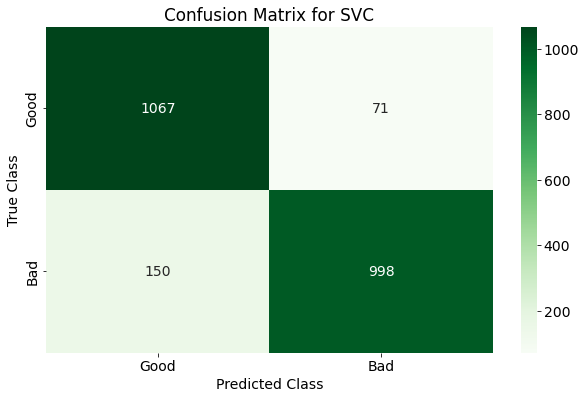

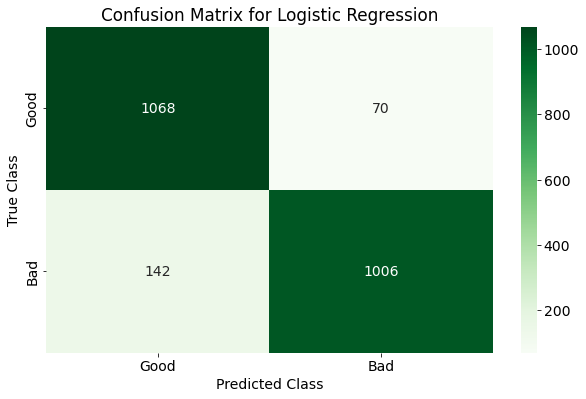

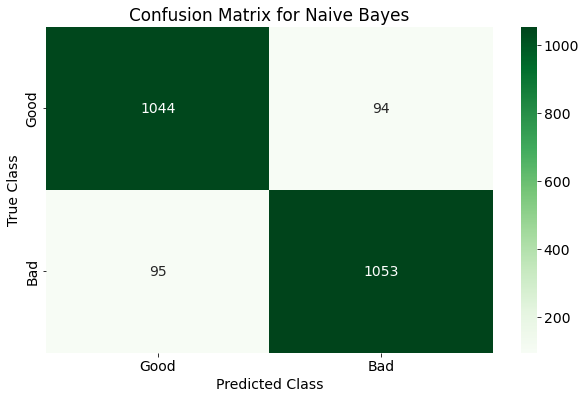

In [128]:
results("SVC" , svc_clf)
results("Logistic Regression" , log_clf)
results("Naive Bayes" , nb_clf)

##### "As we see the NB performs best out of the three followed by MultinomialNB. While Logistic Regression performs the worst, we can see it produces less false negatives than Naive Bayes."

##### "Also if numerical features are removed, logistic regression performs better. I wouldn't know why this would be the case and would be interested to hear some ideas for it."

## Feature Importance

##### Finally, to see what features are most strongly weighted to the SVC classifier, use eli5 to show this. Note that weights may be high for rarer features and should be taken with a grain of salt.

In [129]:
onehot_columns = list(svc_clf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names(input_features=categorical_features))
domvect_columns = list(svc_clf.named_steps['preprocessor'].named_transformers_['domvec'].named_steps['tf'].get_feature_names())
pathvect_columns = list(svc_clf.named_steps['preprocessor'].named_transformers_['pathvec'].named_steps['tf'].get_feature_names())
numeric_features_list = list(numeric_features)
numeric_features_list.extend(onehot_columns)
numeric_features_list.extend(domvect_columns)
numeric_features_list.extend(pathvect_columns)
eli5.explain_weights(svc_clf.named_steps['classifier'], top=20, feature_names=numeric_features_list)

Explanation(estimator='LinearSVC()', description="\nFeatures with largest coefficients per class.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n", error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target='0', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='path_hyphens', weight=3.670000029279404, std=None, value=None), FeatureWeight(feature='www', weight=3.1409762013274567, std=None, value=None), FeatureWeight(feature='silhouettesfree', weight=1.5741953416169454, std=None, value=None), FeatureWeight(feature='idevaffiliate', weight=1.5155094946176055, std=None, value=None), FeatureWeight(feature='wordpress', weight=1.481751747151565, std=None, value=None), FeatureWeight(feature='clioadams', weight=1.4575791291666491, std=None, value=None)], neg=[FeatureWeight(feature='tld_mx', weight=-3.1673169681207893, std=None, value=None), FeatureWeight(feature='length', weight=-2.8794553816603665, std=None, value=None), FeatureWeight(feature='slashes', weight=-2.7514940563754116, std=None, value=None), FeatureWeight(feature='labanquepostale', weight=-1.8285687853152615, std=None, value=None), FeatureWeight(feature='wp', weight=-1.8099229674804014, std=None, value=None), FeatureWeight(feature='pass', weight=-1.770263264255608, std=None, value=None), FeatureWeight(feature='appspot', weight=-1.758947619010604, std=None, value=None), FeatureWeight(feature='webhostapp', weight=-1.6431818664735958, std=None, value=None), FeatureWeight(feature='hop', weight=-1.6244701715594927, std=None, value=None), FeatureWeight(feature='domain_hyphens', weight=-1.578083043798917, std=None, value=None), FeatureWeight(feature='com', weight=-1.5236101718548642, std=None, value=None), FeatureWeight(feature='apogeesourceinc', weight=-1.4812997620047992, std=None, value=None), FeatureWeight(feature='starshipsandqueens', weight=-1.4799930761174784, std=None, value=None), FeatureWeight(feature='php', weight=-1.4704249227886053, std=None, value=None)], pos_remaining=6148, neg_remaining=5838), proba=None, score=None, weighted_spans=None, heatmap=None), TargetExplanation(target='1', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='tld_mx', weight=3.1669014439204317, std=None, value=None), FeatureWeight(feature='length', weight=2.884164016110056, std=None, value=None), FeatureWeight(feature='slashes', weight=2.7311200643064444, std=None, value=None), FeatureWeight(feature='labanquepostale', weight=1.8289281198569833, std=None, value=None), FeatureWeight(feature='wp', weight=1.8153378914147587, std=None, value=None), FeatureWeight(feature='pass', weight=1.7706111411000005, std=None, value=None), FeatureWeight(feature='appspot', weight=1.689541360997138, std=None, value=None), FeatureWeight(feature='webhostapp', weight=1.6431051139001265, std=None, value=None), FeatureWeight(feature='hop', weight=1.6244109021245805, std=None, value=None), FeatureWeight(feature='domain_hyphens', weight=1.5939985080017038, std=None, value=None), FeatureWeight(feature='com', weight=1.5245488986370035, std=None, value=None), FeatureWeight(feature='apogeesourceinc', weight=1.4785617686458625, std=None, value=None), FeatureWeight(feature='starshipsandqueens', weight=1.4772588918747822, std=None, value=None), FeatureWeight(feature='php', weight=1.4709772250409128, std=None, value=None)], neg=[FeatureWeight(feature='path_hyphens', weight=-3.671886194075153, std=None, value=None), FeatureWeight(feature='www', weight=-3.13977799095156, std=None, value=None), FeatureWeight(feature='silhouettesfree', weight=-1.5751668107329715, std=None, value=None